# SigNet : Writer Independent Offline Signature Verification
- Source: https://github.com/AtharvaKalsekar/SigNet
  - Keras: https://github.com/AtharvaKalsekar/SigNet/blob/master/signet_keras.ipynb

## Initialization

In [7]:
!ls -al .
#!pip install natsort

total 152
drwxrwxr-x 3 ubuntu ubuntu   4096 Nov 14 20:21 .
drwxrwxr-x 6 ubuntu ubuntu   4096 Nov 14 11:31 ..
drwxrwxr-x 2 ubuntu ubuntu   4096 Nov 14 13:38 .ipynb_checkpoints
-rw-rw-r-- 1 ubuntu ubuntu 138683 Nov 14 20:21 SigNet-01.ipynb
-rw-rw-r-- 1 ubuntu ubuntu      1 Nov 14 13:37 untitled.txt


In [8]:
DATASETS_PATH_ = "../data/"
DATASET_CEDAR1_PATH_ = "../data/cedar1/"
MODELS_PATH_ = "../models/"

PATH_ORG = DATASET_CEDAR1_PATH_ + "full_org/"
PATH_FORG = DATASET_CEDAR1_PATH_ + "full_forg/"

## Wrappers

In [9]:
import os
from natsort import natsorted, ns
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import numpy as np

def get_image_list():
  org_signs = os.listdir(PATH_ORG)
  forg_signs = os.listdir(PATH_FORG)
  org_signs = [s for s in org_signs if s.endswith(".png")]
  forg_signs = [s for s in forg_signs if s.endswith(".png")]
  org_signs = natsorted(org_signs, alg=ns.IGNORECASE)
  forg_signs = natsorted(forg_signs, alg=ns.IGNORECASE)
  return org_signs, forg_signs

# data cleaning
def check_lists(org_signs,forg_signs):
  flag = False
  for i in range(len(org_signs)):
    org_ext = org_signs[i][8:]
    forg_ext = forg_signs[i][9:]
    if org_ext != forg_ext:
      flag = True
      #print(i,org_ext,forg_ext)
  '''if(flag):
    #print("Mismatches found")
  else:
    #print("No mismatch found")
'''
def refine_lists(org_signs,forg_signs):
  refined_org_signs = []
  for i in range(len(org_signs)):
    if "_41_" in org_signs[i]:
      continue
    refined_org_signs.append(org_signs[i])
  
  refined_forg_signs = []
  for i in range(len(forg_signs)):
    if "_41_" in forg_signs[i]:
      continue
    refined_forg_signs.append(forg_signs[i])
  return refined_org_signs, refined_forg_signs

def get_clean_lists():
  org_signs, forg_signs = get_image_list()
  check_lists(org_signs,forg_signs)
  org_signs, forg_signs = refine_lists(org_signs,forg_signs)
  #print(len(org_signs),len(forg_signs))
  check_lists(org_signs,forg_signs)
  return org_signs, forg_signs

def get_dataframe(org_signs,forg_signs):
  no_of_ppl = len(org_signs)//24

  raw_data = {"image_1":[], "image_2":[], "label":[]}
  for i in range(no_of_ppl):
    i1_batch_1 = []
    i1_batch_2 = []
    i2_batch = []

    start = i*24
    end = (i+1)*24

    for j in range(start,end): 
      i1_batch_1.append(os.path.join(PATH_ORG,org_signs[j]))
      i1_batch_2.append(os.path.join(PATH_ORG,org_signs[j]))
      raw_data["label"].append(1)#0

    temp_rot = (i1_batch_1[-12:]+i1_batch_1[:-12])
    i1_batch_1.extend(i1_batch_2)

    for elem in temp_rot:
      i2_batch.append(elem)

    for j in range(start,end): 
      i2_batch.append(os.path.join(PATH_FORG,forg_signs[j]))
      raw_data["label"].append(0)#1

    raw_data["image_1"].extend(i1_batch_1)
    raw_data["image_2"].extend(i2_batch)
  df = pd.DataFrame(raw_data, columns = ["image_1","image_2","label"])
  df=df.reindex(np.random.permutation(df.index))
  return df


def get_dataset(=None):
  org_signs,forg_signs = get_clean_lists()
  df = get_dataframe(org_signs,forg_signs)
  #print(df.shape)
  train_set, val_set = train_test_split(df,test_size=0.3,random_state=0)
  if(subset.lower()=="train"):
    dataset = train_set
  else:
    dataset = val_set
  return dataset

In [10]:
import numpy as np
import keras
from PIL import Image
import cv2

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, dim=(155,220), n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        rows = [self.df.iloc[k] for k in indexes]
        X, y = self.__data_generation(rows)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(self.df.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, rows):
        x_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        x_2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(rows)):
            image_1 = cv2.imread(rows[i]["image_1"])
            image_1 = cv2.resize(image_1,(220,155))
            image_1 = cv2.bitwise_not(image_1)
            image_1=np.array(image_1)
            image_2 = cv2.imread(rows[i]["image_2"])
            image_2 = cv2.resize(image_2,(220,155))
            image_2 = cv2.bitwise_not(image_2)
            image_2=np.array(image_2)
            '''mean_center_1 = image_1 - np.mean(image_1, axis = None)
            mean_center_2 = image_2 - np.mean(image_2, axis = None)
            
            std_1 = np.std(image_1)
            std_2 = np.std(image_2)
            if(std_1 == 0 or std_1 == np.nan):
                std_1 = 1
            if(std_2 == 0 or std_2 == np.nan):
                std_2 = 1
            standardized_img_1 = image_1/std_1
            standardized_img_2 = image_2/std_2
            '''
            x_1[i,] = image_1/255
            x_2[i,] = image_2/255
            y[i] = rows[i]["label"]


        return [x_1, x_2], y

In [11]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from keras.models import Model

def get_base_net():
  input = Input(shape=(155,220,3))
  
  conv_1 = Conv2D(filters=96, kernel_size=(11,11))(input)
  batch_norm_1 = BatchNormalization()(conv_1)
  activation_1 = Activation('relu')(batch_norm_1)
  max_pool_1 = MaxPooling2D(pool_size=(3,3))(activation_1)
  
  conv_2 = Conv2D(filters=256, kernel_size=(5,5))(max_pool_1)
  batch_norm_2 = BatchNormalization()(conv_2)
  activation_2 = Activation('relu')(batch_norm_2)
  max_pool_2 = MaxPooling2D(pool_size=(3,3))(activation_1)
  
  dropout_1 = Dropout(rate=0.3)(max_pool_2)
  
  conv_3_a = Conv2D(filters=384, kernel_size=(3,3))(dropout_1)
  activation_3_a = Activation('relu')(conv_3_a)
  conv_3_b = Conv2D(filters=256, kernel_size=(3,3))(activation_3_a)
  activation_3_b = Activation('relu')(conv_3_b)
  max_pool_3 = MaxPooling2D(pool_size=(3,3))(activation_3_b)
  
  dropout_2 = Dropout(rate=0.3)(max_pool_3)
  
  flat_1 = Flatten()(dropout_2)
  fc_1 = Dense(units=1024,activation='relu')(flat_1)
  dropout_3 = Dropout(rate=0.5)(fc_1)
  fc_2 = Dense(units=128,activation='relu')(dropout_3)
  return Model(input,fc_2)

In [12]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [13]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    #print("y_pred",y_pred)
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true)* margin_square)
  
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

## Build Model

In [8]:
from keras.layers import Lambda

input_a = Input(shape=(155,220,3))
input_b = Input(shape=(155,220,3))

base_net = get_base_net()
processed_a = base_net(input_a)
processed_b = base_net(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
from keras import optimizers
optimizer = optimizers.RMSprop()
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

In [1]:
params={
    'dim': (155,220),
    'batch_size': 32,
    'n_channels': 3,
    'shuffle': False
}

#train_set = 2592*0.7 = 1814 == 1814/32 == 56
#val_set = 2592*0.3 = 777 == 777/32 == 24
ds_train = get_dataset("train")
ds_val = get_dataset("val")
train_datagen = DataGenerator(ds_train,**params)
validation_datagen = DataGenerator(ds_val,**params)
model.fit_generator(generator=train_datagen,
                    validation_data=validation_datagen,
                    epochs=12, #30,
                    steps_per_epoch=56, #56,
                    validation_steps=12, #24,
                    use_multiprocessing=True,
                    workers=3) #6)

NameError: name 'get_dataset' is not defined

In [11]:
MODEL_PATH_ = MODELS_PATH_ + "SigNet-20191112-02.h5"
model.save(MODEL_PATH_)

## Evaluate

In [14]:
def predict_(MODEL_PATH_, IMAGE_A_PATH_, IMAGE_B_PATH_):    
    from keras.models import load_model
    mod = load_model(MODEL_PATH_, custom_objects={'contrastive_loss':contrastive_loss})

    from matplotlib.pyplot import imshow
    im_1 = cv2.imread(IMAGE_A_PATH_)
    im_2 = cv2.imread(IMAGE_B_PATH_)  
    im_1 = cv2.resize(im_1,(220,155))
    im_2 = cv2.resize(im_2,(220,155))
    imshow(np.hstack([im_1, im_2]))

    im_1 = cv2.bitwise_not(im_1)
    im_2 = cv2.bitwise_not(im_2)
    im_1 = im_1/255
    im_2 = im_2/255
    im_1 = np.expand_dims(im_1,axis=0)
    im_2 = np.expand_dims(im_2,axis=0)
    y_pred = mod.predict([im_1,im_2])

    print(y_pred[0][0], "genuine" if y_pred[0][0] < 0.5 else "forged" if y_pred[0][0] > 1 else "50-50")








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.12592286 genuine


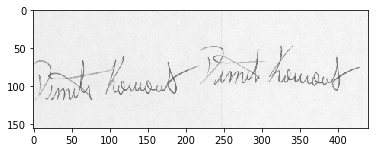

In [15]:
%matplotlib inline
MODEL_PATH_ = MODELS_PATH_ + "SigNet-20191112-02.h5"
ORIGINAL_IMAGE_PATH_ = PATH_ORG + "original_13_1.png"
GENUINE_IMAGE_PATH_ = PATH_ORG + "original_13_5.png"
FORGED_IMAGE_PATH_ = PATH_FORG + "forgeries_13_1.png"

predict_(MODEL_PATH_, ORIGINAL_IMAGE_PATH_, GENUINE_IMAGE_PATH_)

1.0487709 forged


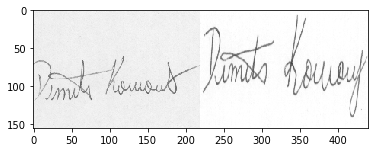

In [16]:
%matplotlib inline
predict_(MODEL_PATH_, ORIGINAL_IMAGE_PATH_, FORGED_IMAGE_PATH_)

1.0446825 forged


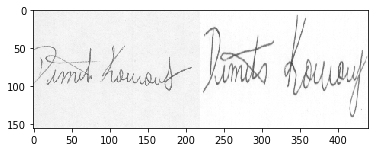

In [17]:
%matplotlib inline
predict_(MODEL_PATH_, GENUINE_IMAGE_PATH_, FORGED_IMAGE_PATH_)